# Базовое решение задачи kaggle "Classification of butterflies"

Описание задачи и данные:

https://www.kaggle.com/c/classification-of-butterflies/data

In [ ]:
# сохраним все данные в папку на гугл диске
# монтируем гугл диск в colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import re
import pandas as pd
import os

# с помощью библиотеки os перейдем в папку где лежат данные
url = os.chdir(r"./gdrive/MyDrive/Я-профи подготовка по машинному обучению/butterfles")
os.getcwd()

'/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/butterfles'

In [ ]:
# os.listdir - команда позволяет посмотреть все каталоги и файлы в текущей директории
os.listdir(os.getcwd())

['train_butterflies', 'test_butterflies', 'valid', 'predictions.csv']

## Считывание данных

Для применения алгоритмов ML необходимо чтобы изображения были одного размера, но нам повезло по условию, они уже все одного размера

Метод фреймворка Tensorflow `image_dataset_from_directory` - Позволяет их картинок создать тренировочный набор данных, картинки размещены по разным папкам, что и является разметкой классов по сути

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
import tensorflow as tf

In [ ]:
# считаем тренировочные данные

# 224 - ширина, 224 - высота, 3 - количество каналов (для цветных картинок RGB - значит 3 канала)
img_shape=(224,224,3)

# train_dir - путь до тренировочных данных
train_dir = os.path.join('train_butterflies/train_split')

img_size = (img_shape[0], img_shape[1])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    seed=123,
    batch_size=15)

Found 4705 files belonging to 50 classes.


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_genarator = ImageDataGenerator(rescale=1. /255)

# train_genarator.flow_from_directory()

In [ ]:
valid_dir = os.path.join('valid')
img_size = (img_shape[0], img_shape[1])
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    image_size=img_size,
    seed=123,
    batch_size=15)

Found 250 files belonging to 50 classes.


In [ ]:
# считаем тестовые данные
# label_mode - установлен как None, потому что тестовые данные не размеченные
# Остальные параменты должны совпадать с тренировных набором данны

# test_dir - путь до тестовых данных
test_dir = os.path.join('test_butterflies/valid')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = None,
    image_size=img_size,
    batch_size=15)

Found 250 files belonging to 1 classes.


In [ ]:
# train_ds - созданный набор тренировочных данных созданный с помощью Tensorflow
# class_names - метод объекта данных Tensorflow который возвращает список всех классов в виде списка
class_names = train_ds.class_names

# всего 50 классов, что мы собственно и видим после того как считали тренировочные данные
class_count = len(class_names)

In [ ]:
# названия классов совпадают с названием папок
class_names

['class_0',
 'class_1',
 'class_10',
 'class_11',
 'class_12',
 'class_13',
 'class_14',
 'class_15',
 'class_16',
 'class_17',
 'class_18',
 'class_19',
 'class_2',
 'class_20',
 'class_21',
 'class_22',
 'class_23',
 'class_24',
 'class_25',
 'class_26',
 'class_27',
 'class_28',
 'class_29',
 'class_3',
 'class_30',
 'class_31',
 'class_32',
 'class_33',
 'class_34',
 'class_35',
 'class_36',
 'class_37',
 'class_38',
 'class_39',
 'class_4',
 'class_40',
 'class_41',
 'class_42',
 'class_43',
 'class_44',
 'class_45',
 'class_46',
 'class_47',
 'class_48',
 'class_49',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

**Обратите внимание `class_10` - это класс 10, а не 2 (как было бы при переименовании с помощью готовых инструментов, они сортируют в лексиграфическом порядке!!!)**

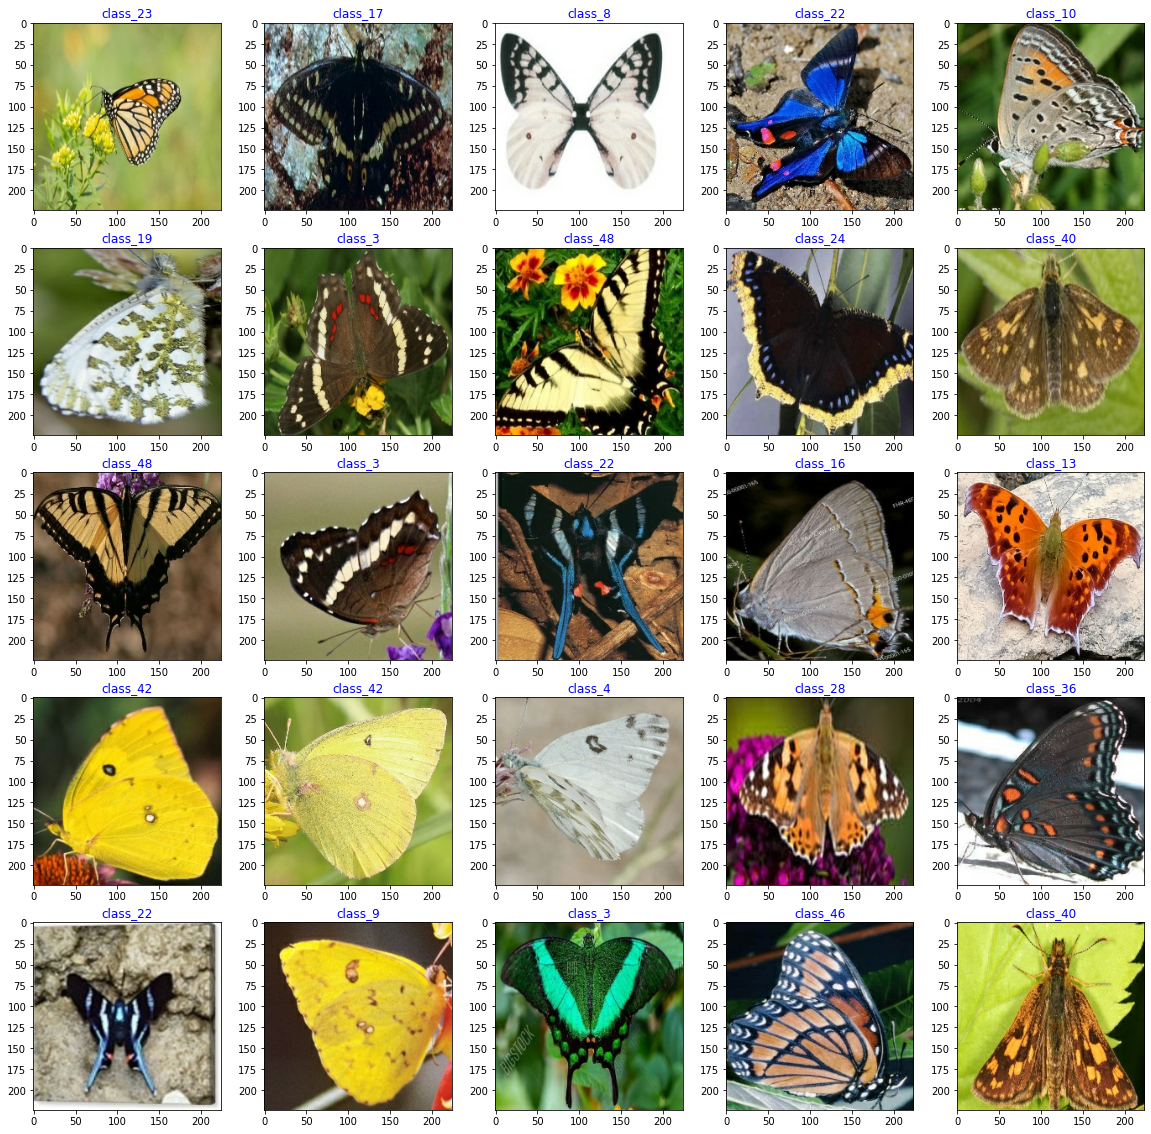

In [ ]:
# посмотрим на некоторые картинки из набора тренировочных данных
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

for images, labels in train_ds.take(1):
    for i in range (25):
        plt.subplot(5,5,i +1)
        img=images[i]/255
        plt.title(class_names[labels[i]], color='blue', fontsize=12)
        plt.imshow(img)
    plt.show()

## Построение модели

**Слой `Input`**

Помимо функциональных слоев в Keras существуют вспомогательные слои и один из них определяется классом `Input`.

Как вы уже догадались, этот слой служит для описания формы входных данных. То есть, если модель не имеет слоя Input, то размерность входного вектора устанавливается по входному тензору при первом вызове.

Но, если явно указать размерность через класс Input, то модель сети строится сразу с начальным набором весов.

Нейронная сеть архитектуры **EfficientNetB3**, которая обучена на наборе данных UTKFace DataSet.

Возьмем готовую архитектуру для решения задачи (можете еще ResNet попробовать).

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB3

`Model` - Модель это (обычно) граф слоев.


https://www.tensorflow.org/api_docs/python/tf/keras/Model

`Adamax` – вариант оптимизации по Adam, но без ограничений по норме.

Модели глубоко обучения

https://keras.io/api/applications/#xception

In [ ]:
%%time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

input = Input(shape = img_shape)

x = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", pooling='max')(input)
# x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dropout(rate=.4, seed=123)(x)

output = Dense(class_count, activation='softmax')(x)

model = Model(inputs = input, outputs = output)

# model.compile(Adamax(lr=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.compile(
    optimizer = Adamax(lr=.001),
    loss = tf.losses.SparseCategoricalCrossentropy(),
    # CategoricalCrossentropy()
    metrics = ['accuracy'])

history = model.fit(train_ds, validation_data = valid_ds, epochs = 3, verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


Epoch 1/3
314/314 [==============================] - 111s 307ms/step - loss: 2.3458 - accuracy: 0.5464 - val_loss: 0.3700 - val_accuracy: 0.8960
Epoch 2/3
314/314 [==============================] - 94s 298ms/step - loss: 0.4017 - accuracy: 0.8820 - val_loss: 0.3136 - val_accuracy: 0.9200
Epoch 3/3
314/314 [==============================] - 93s 295ms/step - loss: 0.2100 - accuracy: 0.9343 - val_loss: 0.3065 - val_accuracy: 0.9440
CPU times: user 5min 11s, sys: 12.9 s, total: 5min 24s
Wall time: 5min 49s


In [ ]:
# Предскажем значения для тестового набора данных
preds = model.predict(test_ds, verbose=1)
preds

17/17 [==============================] - 3s 63ms/step


array([[2.0595569e-07, 2.1827694e-07, 3.5252020e-07, ..., 1.2094407e-06,
        3.4587879e-06, 2.1024303e-07],
       [2.5693431e-05, 1.9122319e-02, 1.3260417e-06, ..., 5.3932905e-07,
        1.3953404e-05, 7.9992597e-06],
       [6.5443601e-10, 3.6410144e-09, 1.9607260e-08, ..., 1.7216788e-09,
        9.9998856e-01, 3.8183930e-07],
       ...,
       [6.7527543e-07, 1.7637043e-07, 7.8188568e-06, ..., 2.8975714e-08,
        1.9252232e-07, 5.9754498e-06],
       [9.4566877e-10, 2.1502362e-11, 2.5759210e-08, ..., 1.1388971e-08,
        8.0277550e-06, 3.8257311e-11],
       [2.8900118e-10, 2.9904873e-10, 2.0220941e-11, ..., 9.9999583e-01,
        1.8210350e-11, 1.9232946e-10]], dtype=float32)

In [ ]:
import numpy as np

ypred = []
errors = 0
count = 0

for i, p in enumerate(preds):
    index = np.argmax(p)
    klass = class_names[index]
    ypred.append(klass)

ypred = np.array(ypred)

In [ ]:
ypred
# class_1

In [ ]:
df = pd.DataFrame(ypred, columns=['label'])
df['label'] = df['label'].str.replace(r"class_",'')
df['label'] = df['label'].astype(int)
df

,label
0,39
1,38
2,8
3,10
4,29
...,...
245,32
246,28
247,34
248,17


In [ ]:
df = df.reset_index()
df

,index,label
0,0,39
1,1,38
2,2,8
3,3,10
4,4,29
...,...,...
245,245,32
246,246,28
247,247,34
248,248,17


In [ ]:
from google.colab import files

df.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>